In [2]:
import numpy as np
import pandas as pd 
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns

Using TensorFlow backend.


Total Data : 54338
Bukan Dewasa : 27192
Dewasa : 27146


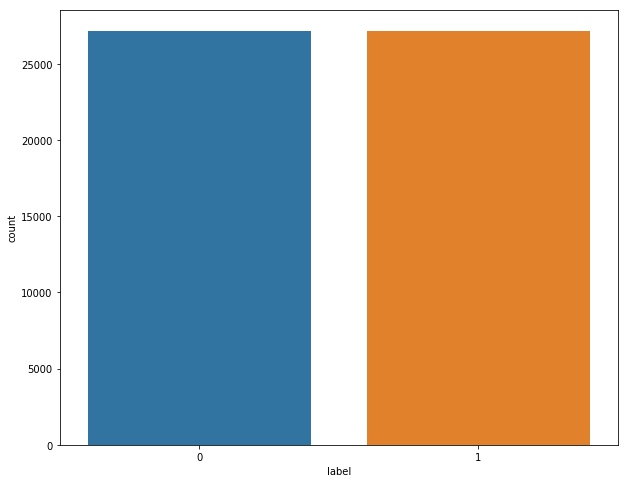

In [3]:
data = pd.read_excel("data/label/combineSSL1.xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True) # memastikan tidak ada nilai yang kosong
dewasa = data.loc[data['label'] == 1, 'tweet'].copy().reset_index(drop=True)
bukan = data.loc[data['label'] == 0, 'tweet'].copy().reset_index(drop=True)
print("Total Data :", len(data))
print("Bukan Dewasa :", len(bukan))
print("Dewasa :", len(dewasa))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [0]:
# Splitting Data
text = data['tweet'].values
label = data['label'].values
data_train, data_test, label_train, label_test = train_test_split(text, label, test_size=0.33, random_state=42)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size= 0.33, random_state=42)

In [0]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab = max([len(tokenizer.word_index)]) + 1 # kamus kata 
maxlen = max([len(i.split()) for i in text]) # panjang input sequence
batch_size = 32 # penentuan jumlah sample yang ditraining pada tiap epoch
num_epochs = 20 # banyak iterasi pada saat training model 
initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=2) # mengatur angka random weigth

In [0]:
#Data Train
X_train = tokenizer.texts_to_sequences(data_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = to_categorical(label_train, num_classes = 2)

#Data Test
X_test = tokenizer.texts_to_sequences(data_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_test = to_categorical(label_test, num_classes = 2)

#Data Validation
X_val = tokenizer.texts_to_sequences(data_val)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_val = to_categorical(label_val, num_classes = 2)

In [0]:
def get_model1(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 32, input_length = maxlen, embeddings_initializer = initializer))
    model.add(LSTM(32, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model2(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0,max(history.epoch)])
        
def evaluation(model, X, Y):
    # Predict the values
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    Y_act = Y
    # accuracy
    accuracy = accuracy_score(Y_act, Y_pred_class)
    print("Accuracy: %.2f" % (accuracy*100), "%")
    # precision
    precision = precision_score(Y_act, Y_pred_class)
    print("Precision: %.2f" % (precision*100), "%")
    # recall
    recall = recall_score(Y_act, Y_pred_class)
    print("Recall: %.2f" % (recall*100), "%")
    
    return Y_act, Y_pred_class

def conf_matrix(Y_act, Y_pred):
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_act, Y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d");
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Model 1

In [27]:
model1 = get_model1(X_train, Y_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 58, 32)            1325248   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 1,333,634
Trainable params: 1,333,634
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# training model
history1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 24392 samples, validate on 12014 samples
Epoch 1/20
24392/24392 [==============================] - 112s 5ms/step - loss: 0.2230 - acc: 0.9059 - val_loss: 0.0635 - val_acc: 0.9840
Epoch 2/20
24392/24392 [==============================] - 110s 4ms/step - loss: 0.0429 - acc: 0.9887 - val_loss: 0.0630 - val_acc: 0.9829
Epoch 3/20
24392/24392 [==============================] - 109s 4ms/step - loss: 0.0206 - acc: 0.9945 - val_loss: 0.1041 - val_acc: 0.9744
Epoch 4/20
24392/24392 [==============================] - 109s 4ms/step - loss: 0.0121 - acc: 0.9971 - val_loss: 0.0857 - val_acc: 0.9775
Epoch 5/20
24392/24392 [==============================] - 109s 4ms/step - loss: 0.0072 - acc: 0.9983 - val_loss: 0.0800 - val_acc: 0.9837
Epoch 6/20
24392/24392 [==============================] - 109s 4ms/step - loss: 0.0078 - acc: 0.9983 - val_loss: 0.1185 - val_acc: 0.9744
Epoch 7/20
24392/24392 [==============================] - 110s 4ms/step - loss: 0.0060 - acc: 0.9982 - val_loss: 0.0930 - 

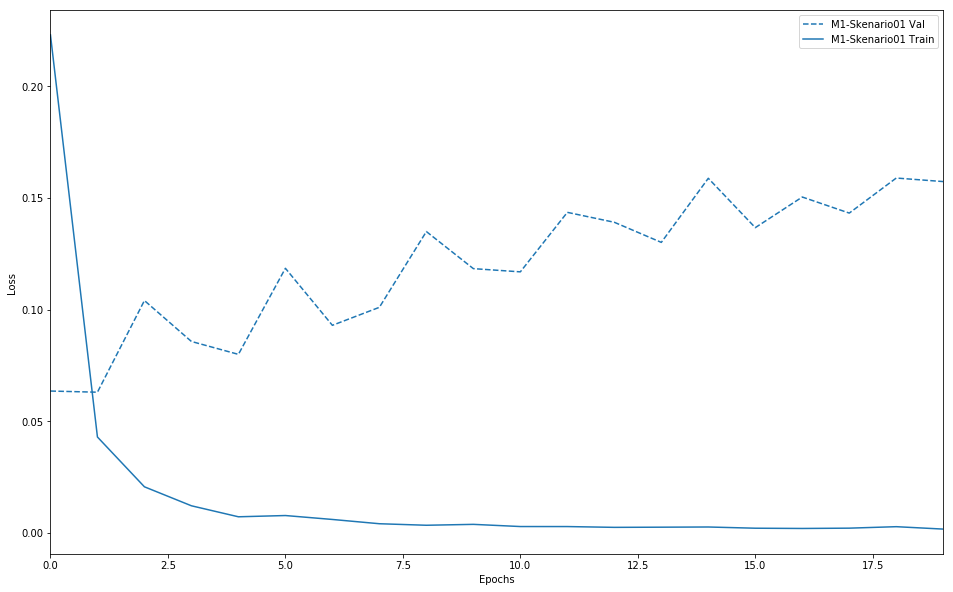

In [29]:
plot_history([('M1-Skenario01', history1)])

# Evaluasi 1

Evaluasi Data Test
Accuracy: 97.56 %
Precision: 97.84 %
Recall: 97.17 %


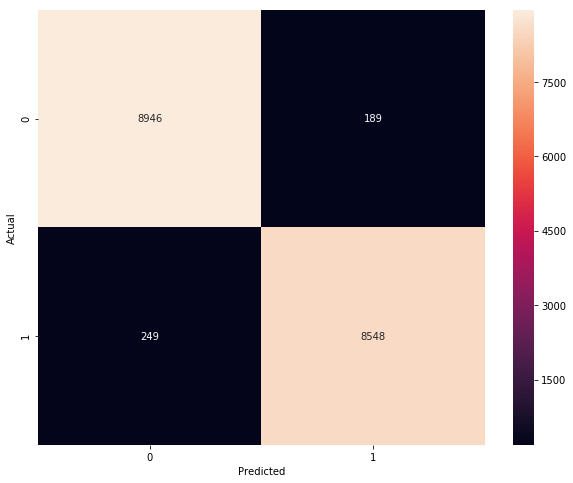

In [30]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model1, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.95 %
Precision: 99.97 %
Recall: 99.93 %


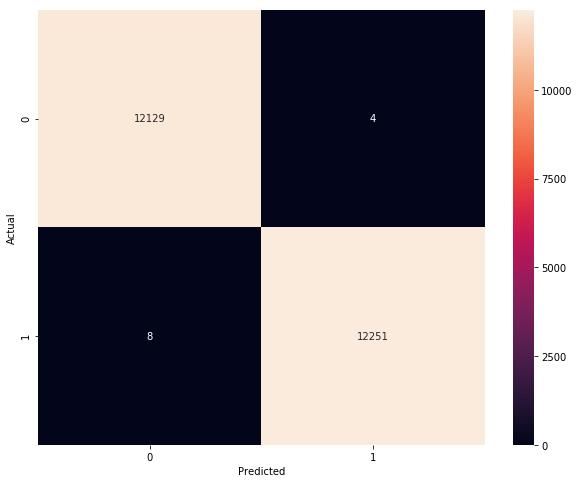

In [31]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model1, X_train, label_train)
conf_matrix(Y_act, Y_pred)

# Model 2

In [20]:
model2 = get_model2(X_train, Y_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 58, 128)           5300992   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 5,432,834
Trainable params: 5,432,834
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# training model
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 24392 samples, validate on 12014 samples
Epoch 1/20
24392/24392 [==============================] - 117s 5ms/step - loss: 0.1626 - acc: 0.9364 - val_loss: 0.0593 - val_acc: 0.9843
Epoch 2/20
24392/24392 [==============================] - 116s 5ms/step - loss: 0.0369 - acc: 0.9896 - val_loss: 0.0711 - val_acc: 0.9817
Epoch 3/20
24392/24392 [==============================] - 117s 5ms/step - loss: 0.0176 - acc: 0.9952 - val_loss: 0.0774 - val_acc: 0.9791
Epoch 4/20
24392/24392 [==============================] - 116s 5ms/step - loss: 0.0117 - acc: 0.9967 - val_loss: 0.0710 - val_acc: 0.9813
Epoch 5/20
24392/24392 [==============================] - 115s 5ms/step - loss: 0.0053 - acc: 0.9988 - val_loss: 0.0907 - val_acc: 0.9816
Epoch 6/20
24392/24392 [==============================] - 117s 5ms/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.1080 - val_acc: 0.9816
Epoch 7/20
24392/24392 [==============================] - 116s 5ms/step - loss: 0.0043 - acc: 0.9989 - val_loss: 0.1863 - 

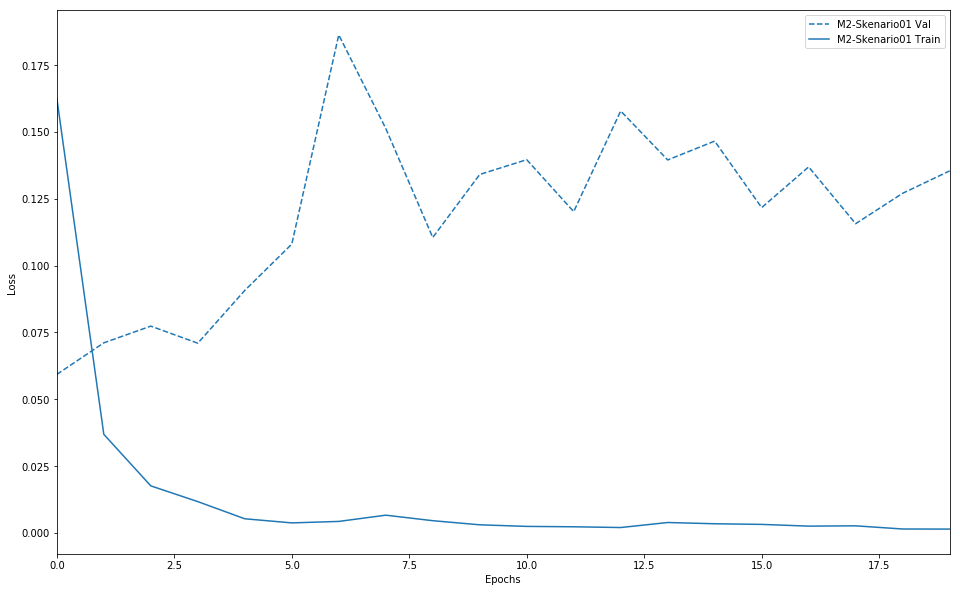

In [22]:
plot_history([('M2-Skenario01', history2)])

# Evaluasi 2

Evaluasi Data Test
Accuracy: 97.84 %
Precision: 97.08 %
Recall: 98.57 %


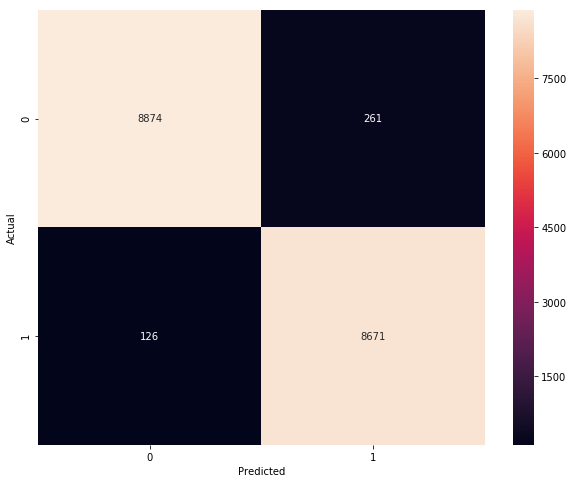

In [23]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model2, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.94 %
Precision: 99.97 %
Recall: 99.92 %


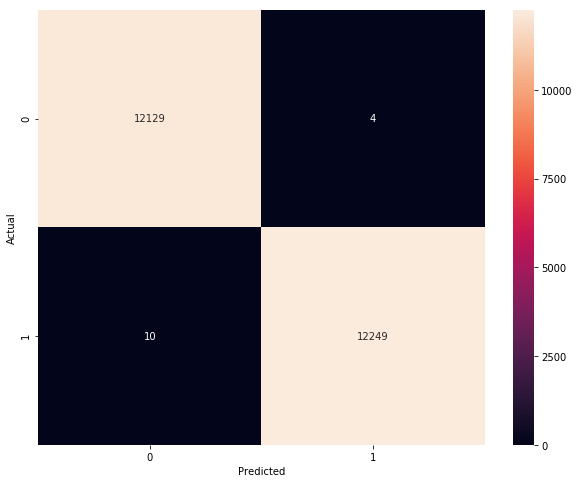

In [24]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model2, X_train, label_train)
conf_matrix(Y_act, Y_pred)

# Grafik Keseluruhan 

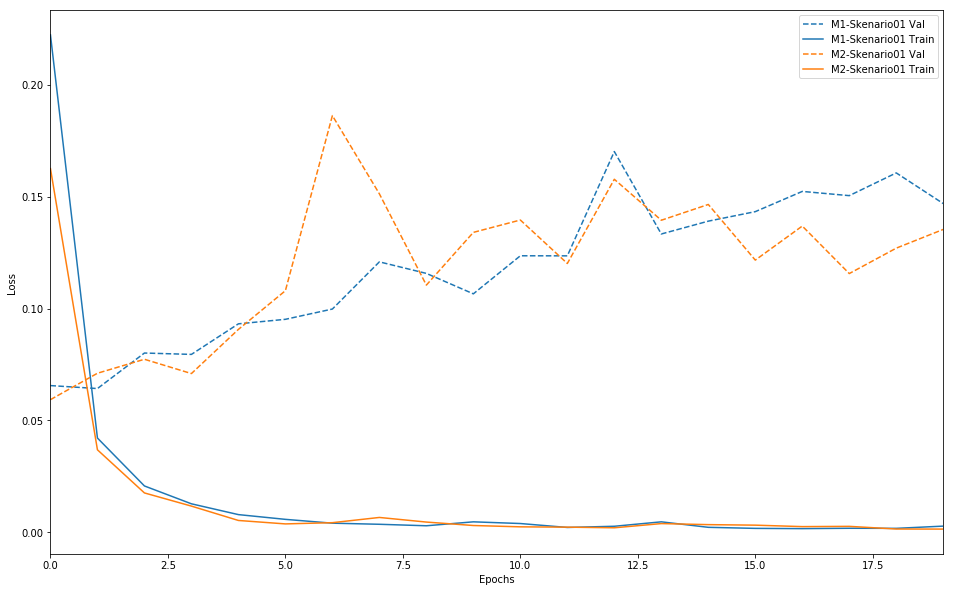

In [25]:
plot_history([('M1-Skenario01', history1),
              ('M2-Skenario01', history2)])

# Save Model

In [0]:
model1.save('model/M1-Skenario01.h5')
model2.save('model/M2-Skenario01.h5')